In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from util.data_management import load_data_AE, concate_data, stack_data, load_data, split_data
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline 
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from numpy.random import seed
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn import metrics
from scipy.io.arff import loadarff
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import glob
import os
from tqdm import tqdm

In [2]:
## normal / abnormal (sample rate : 4000 -> 17s)
# 20211015 48 / -
# 20220112 10 / 16
# 20220121 995 / 741
# 20220208 1691 / -
# 20220209 1273 / -
# 20220310 5158 / - 
# 20220311 1563 / -
# 20220315 1874 / -
# 20220323 - / 2129
# 20220331 - / 1460
# normal 전체 17m 소요, abnormal 전체 6m 소요

dir_list = os.listdir(r"C:\Users\VIP444\Documents\Anomaly-Dataset\sar400_vibration_data")
data_0_all = []
data_1_all = []
data_2_all = []
data_3_all = []

for idx, dir in enumerate(tqdm(dir_list)):
    file_path_list = glob.glob(rf"C:\Users\VIP444\Documents\Anomaly-Dataset\sar400_vibration_data\{dir}\*_continuous.xlsx")
    
    if file_path_list != []:
        data_0_all.append(load_data_AE(file_path_list[0]))
        data_1_all.append(load_data_AE(file_path_list[1]))
        data_2_all.append(load_data_AE(file_path_list[2]))
        data_3_all.append(load_data_AE(file_path_list[3]))
    
    # if idx == 3:
    #     break

fault_data_0_all = []
fault_data_1_all = []
fault_data_2_all = []
fault_data_3_all = []

for idx, dir in enumerate(tqdm(dir_list)):
    file_path_list = glob.glob(rf"C:\Users\VIP444\Documents\Anomaly-Dataset\sar400_vibration_data\{dir}\*_continuous_*fault.xlsx")

    if file_path_list != []:
        fault_data_0_all.append(load_data_AE(file_path_list[0]))
        fault_data_1_all.append(load_data_AE(file_path_list[1]))
        fault_data_2_all.append(load_data_AE(file_path_list[2]))
        fault_data_3_all.append(load_data_AE(file_path_list[3]))
    
    # if idx == 2:
    #     break

 10%|█         | 1/10 [00:04<00:37,  4.13s/it]

0 complete.


 20%|██        | 2/10 [00:05<00:18,  2.26s/it]

1 complete.


 30%|███       | 3/10 [01:26<04:28, 38.32s/it]

2 complete.


 40%|████      | 4/10 [03:42<07:40, 76.78s/it]

3 complete.


 50%|█████     | 5/10 [05:25<07:12, 86.51s/it]

4 complete.


 60%|██████    | 6/10 [12:25<13:19, 199.94s/it]

5 complete.


 70%|███████   | 7/10 [14:33<08:49, 176.38s/it]

6 complete.


100%|██████████| 10/10 [17:06<00:00, 102.68s/it]


7 complete.
8 complete.
9 complete.


100%|██████████| 10/10 [05:56<00:00, 35.65s/it]


In [72]:
data_0_concate = concate_data(data_0_all, axis=0)
data_1_concate = concate_data(data_1_all, axis=0)
data_2_concate = concate_data(data_2_all, axis=0)
data_3_concate = concate_data(data_3_all, axis=0)
test_data_0 = concate_data(fault_data_0_all, axis=0)
test_data_1 = concate_data(fault_data_1_all, axis=0)
test_data_2 = concate_data(fault_data_2_all, axis=0)
test_data_3 = concate_data(fault_data_3_all, axis=0)

data_0 = []
data_1 = []
data_2 = []
data_3 = []

for elem_0, elem_1, elem_2, elem_3 in zip(data_0_concate, data_1_concate, data_2_concate, data_3_concate):
    if elem_0 >= 0.003 and elem_1 >= 0.003 and elem_2 >= 0.003 and elem_3 >= 0.003:
        data_0.append(elem_0)
        data_1.append(elem_1)
        data_2.append(elem_2)
        data_3.append(elem_3)

data_0 = np.array(data_0)
data_1 = np.array(data_1)
data_2 = np.array(data_2)
data_3 = np.array(data_3)

split_rate = 0.9
split_idx = int(len(data_0)*split_rate)

train_data_0 = data_0[:split_idx]
train_data_1 = data_1[:split_idx]
train_data_2 = data_2[:split_idx]
train_data_3 = data_3[:split_idx]
validation_data_0 = data_0[split_idx:]
validation_data_1 = data_1[split_idx:]
validation_data_2 = data_2[split_idx:]
validation_data_3 = data_3[split_idx:]

print(train_data_0.shape)
print(validation_data_0.shape)
print(test_data_0.shape)

(7034, 1)
(782, 1)
(4346, 1)


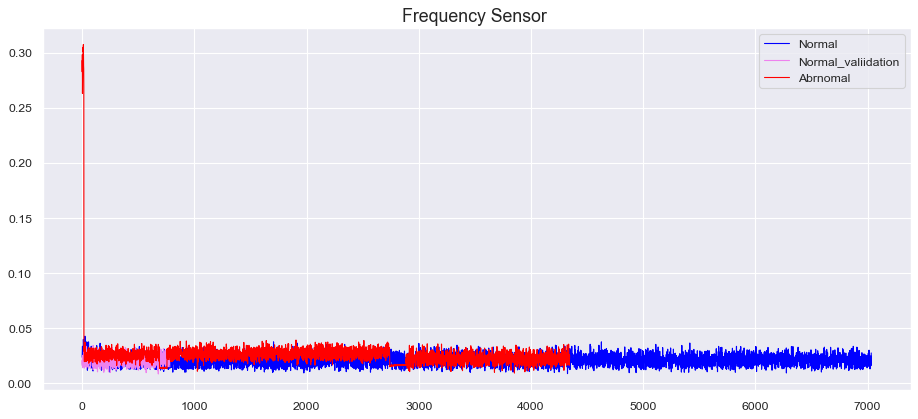

In [83]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_data_3, label='Normal', color='blue', animated = True, linewidth=1)
ax.plot(validation_data_3, label='Normal_valiidation', color='violet', animated = True, linewidth=1)
ax.plot(test_data_3, label='Abrnomal', color='red', animated = True, linewidth=1)
plt.legend(loc='upper right')
ax.set_title('Frequency Sensor ', fontsize=16)
plt.show()

C:\Users\VIP444\Anaconda3\envs\keras\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\VIP444\Anaconda3\envs\keras\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\VIP444\Anaconda3\envs\keras\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


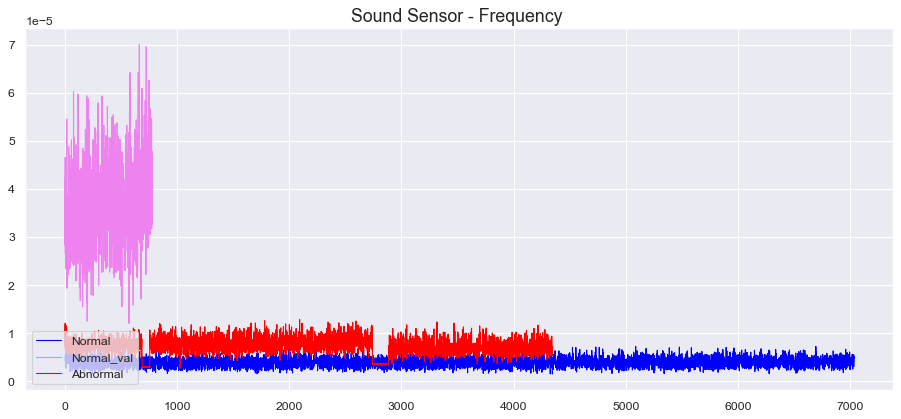

In [13]:
train_fft_0 = np.fft.fft(train_data_0) / len(train_data_0)
train_fft_1 = np.fft.fft(train_data_1) / len(train_data_1)
train_fft_2 = np.fft.fft(train_data_2) / len(train_data_2)
train_fft_3 = np.fft.fft(train_data_3) / len(train_data_3)

validation_fft_0 = np.fft.fft(validation_data_0) / len(validation_data_0)
validation_fft_1 = np.fft.fft(validation_data_1) / len(validation_data_1)
validation_fft_2 = np.fft.fft(validation_data_2) / len(validation_data_2)
validation_fft_3 = np.fft.fft(validation_data_3) / len(validation_data_3)

test_fft_0 = np.fft.fft(test_data_0) / len(test_data_0)
test_fft_1 = np.fft.fft(test_data_1) / len(test_data_1)
test_fft_2 = np.fft.fft(test_data_2) / len(test_data_2)
test_fft_3 = np.fft.fft(test_data_3) / len(test_data_3)
test_fft = np.fft.fft(test_data_0) / len(test_data_0)

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft_1, label='Normal', color='blue', animated = True, linewidth=1)
ax.plot(validation_fft_1, label='Normal_val', color='violet', animated = True, linewidth=1)
ax.plot(test_fft_1, label='Abnormal', color='red', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Sound Sensor - Frequency ', fontsize=16)
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler = MinMaxScaler()
X_train_0 = scaler.fit_transform(train_data_0)
X_train_1 = scaler.transform(train_data_1)
X_train_2 = scaler.transform(train_data_2)
X_train_3 = scaler.transform(train_data_3)

X_validation_0 = scaler.transform(validation_data_0)
X_validation_1 = scaler.transform(validation_data_1)
X_validation_2 = scaler.transform(validation_data_2)
X_validation_3 = scaler.transform(validation_data_3)

X_test_0 = scaler.transform(test_data_0)
X_test_1 = scaler.transform(test_data_1)
X_test_2 = scaler.transform(test_data_2)
X_test_3 = scaler.transform(test_data_3)

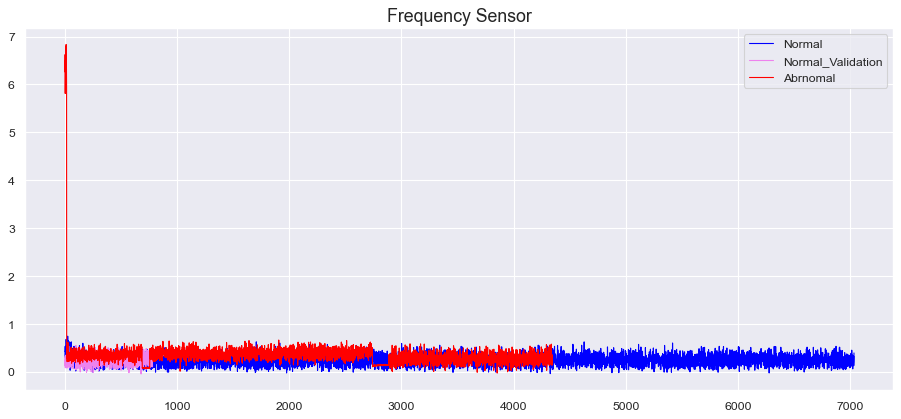

In [80]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(X_train_3, label='Normal', color='blue', animated = True, linewidth=1)
ax.plot(X_validation_3, label='Normal_Validation', color='violet', animated = True, linewidth=1)
ax.plot(X_test_3, label='Abrnomal', color='red', animated = True, linewidth=1)
plt.legend(loc='upper right')
ax.set_title('Frequency Sensor', fontsize=16)
plt.show()

In [23]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(64, activation='relu', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(32, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(32, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(64, activation='relu', return_sequences=True)(L4)

    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [24]:
X_train = concate_data((X_train_0, X_train_1, X_train_2, X_train_3), axis=1)
X_validation = concate_data((X_validation_0, X_validation_1, X_validation_2, X_validation_3), axis=1)
X_test = concate_data((X_test_0, X_test_1, X_test_2, X_test_3), axis=1)

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_validation = X_validation.reshape(X_validation.shape[0], 1, X_validation.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

(7034, 1, 4)
(782, 1, 4)
(4346, 1, 4)


In [25]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 64)             17664     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 32)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 32)             8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 64)             24832     
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 4)              260   

In [26]:
nb_epochs = 100
batch_size = 256

checkpoint_path = "model/checkpoint.pt"

callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1), ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)]
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,callbacks=callbacks, validation_split=0.1).history

model.load_weights(checkpoint_path)
model.save("model/model_concate.h5")

Epoch 1/100
25/25 [==============================] - 4s 35ms/step - loss: 0.2596 - val_loss: 0.2360

Epoch 00001: val_loss improved from inf to 0.23603, saving model to model\checkpoint.pt
Epoch 2/100
25/25 [==============================] - 0s 19ms/step - loss: 0.2053 - val_loss: 0.1716

Epoch 00002: val_loss improved from 0.23603 to 0.17160, saving model to model\checkpoint.pt
Epoch 3/100
25/25 [==============================] - 0s 19ms/step - loss: 0.1290 - val_loss: 0.0824

Epoch 00003: val_loss improved from 0.17160 to 0.08241, saving model to model\checkpoint.pt
Epoch 4/100
25/25 [==============================] - 0s 19ms/step - loss: 0.0646 - val_loss: 0.0509

Epoch 00004: val_loss improved from 0.08241 to 0.05087, saving model to model\checkpoint.pt
Epoch 5/100
25/25 [==============================] - 0s 19ms/step - loss: 0.0498 - val_loss: 0.0411

Epoch 00005: val_loss improved from 0.05087 to 0.04114, saving model to model\checkpoint.pt
Epoch 6/100
25/25 [====================

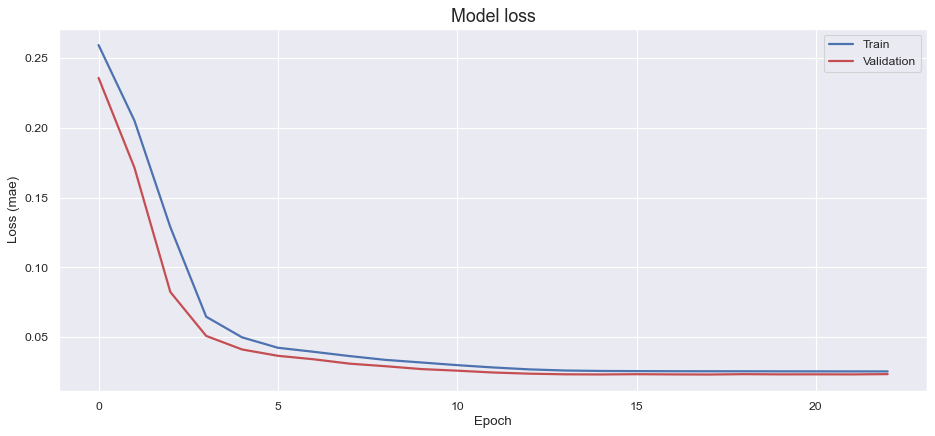

In [27]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

1.0
1.0
2.9627753970041838e-06


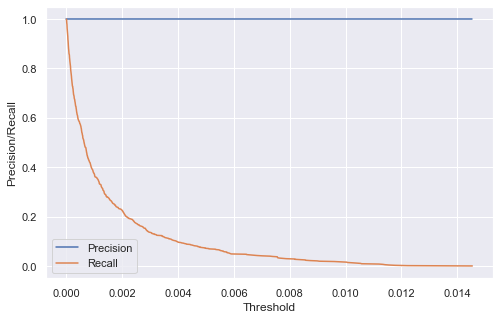

In [63]:
X_validation = concate_data((X_validation_0, X_validation_1, X_validation_2, X_validation_3), axis=1)
X_validation = X_validation.reshape(X_validation.shape[0], 1, X_validation.shape[1])

X_test = concate_data((X_test_0, X_test_1, X_test_2, X_test_3), axis=1)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

model = tf.keras.models.load_model('model/model_concate.h5')
predictons_3d = model.predict(X_validation)
predictions = predictons_3d.reshape(predictons_3d.shape[0], predictons_3d.shape[2])
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[2])
mse = np.mean(np.power(X_validation - predictions, 2), axis=1)

y_valid = np.ones(len(X_validation))

error_df = pd.DataFrame({'Reconstruction_error':mse,
'True_class': y_valid})

precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

best_cnt_dic = abs(precision_rt - recall_rt)
threshold_fixed = threshold_rt[np.argmin(best_cnt_dic)]

print(precision_rt[np.argmin(best_cnt_dic)])
print(recall_rt[np.argmin(best_cnt_dic)])
print(threshold_fixed)

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

C:\Users\VIP444\Anaconda3\envs\keras\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Loss Distribution'}, xlabel='Loss_mae', ylabel='Density'>

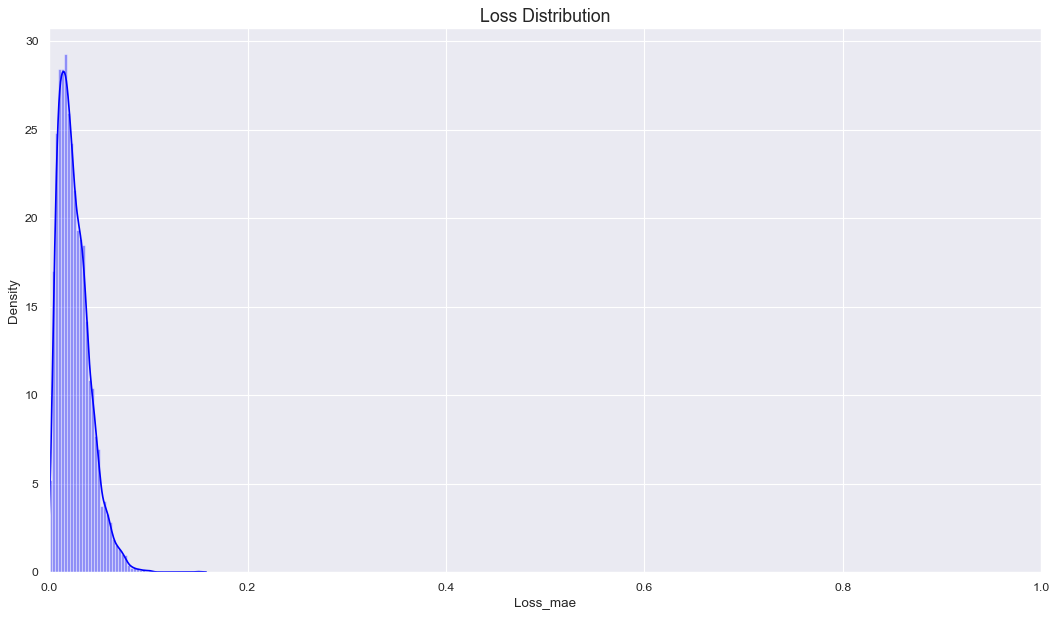

In [64]:
model = tf.keras.models.load_model('model/model_concate.h5')

X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2]) 
X_pred = pd.DataFrame(X_pred)

Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2]) 

scored = pd.DataFrame()
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis=1)
# scored['Loss_mae'] = np.mean(X_pred-Xtrain, axis=1) 

Threshold = 0.017

plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
plt.xlim([0,1])
sns.distplot(scored['Loss_mae'], kde= True, color = 'blue')

In [85]:
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred)

Threshold = 0.3

scored = pd.DataFrame()
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred), axis=1)
scored['Threshold'] = Threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
print(scored)

scored.to_csv('./test_log.csv', sep=',')

       Loss_mae  Threshold  Anomaly
0     18.206680        0.3     True
1     17.679699        0.3     True
2     21.590572        0.3     True
3     15.119682        0.3     True
4     18.381170        0.3     True
...         ...        ...      ...
4341   0.883055        0.3     True
4342   0.645454        0.3     True
4343   0.844889        0.3     True
4344   0.776581        0.3     True
4345   0.926022        0.3     True

[4346 rows x 3 columns]


In [86]:
X_pred

,0,1,2,3
0,20.912298,26.027559,6.240345,19.646519
1,20.311220,25.268547,6.064248,19.074780
2,24.748642,30.903645,7.374326,23.335680
3,17.388746,21.558495,5.221842,16.309649
4,21.107866,26.283775,6.297627,19.835417
...,...,...,...,...
4341,1.153073,1.312958,0.103493,0.962694
4342,0.878990,0.988917,0.012555,0.701356
4343,1.109372,1.261360,0.088259,0.920564
4344,1.031008,1.168348,0.061538,0.845430


In [66]:
X_validation = X_validation.reshape(X_validation.shape[0], 1, X_validation.shape[1])
X_pred_val = model.predict(X_validation)
X_pred_val = X_pred_val.reshape(X_pred_val.shape[0], X_pred_val.shape[2])
X_pred_val = pd.DataFrame(X_pred_val)

scored_val = pd.DataFrame()
Xvalidation = X_validation.reshape(X_validation.shape[0], X_validation.shape[2])
scored_val['Loss_mae'] = np.mean(np.abs(X_pred_val-Xvalidation), axis=1)
scored_val['Threshold'] = Threshold
scored_val['Anomaly'] = scored_val['Loss_mae'] > scored_val['Threshold']
print(scored_val)
scored_val.to_csv('./validation_log.csv', sep=',')

     Loss_mae  Threshold  Anomaly
0    0.010795        0.3    False
1    0.018072        0.3    False
2    0.052332        0.3    False
3    0.029803        0.3    False
4    0.018992        0.3    False
..        ...        ...      ...
777  0.028247        0.3    False
778  0.026522        0.3    False
779  0.039414        0.3    False
780  0.033321        0.3    False
781  0.044249        0.3    False

[782 rows x 3 columns]


In [68]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred)

Threshold = 0.3

scored = pd.DataFrame()
Xtest = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred), axis=1)
scored['Threshold'] = Threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
print(scored)

scored.to_csv('./train_log.csv', sep=',')

      Loss_mae  Threshold  Anomaly
0     0.321283        0.3     True
1     0.377073        0.3     True
2     0.401993        0.3     True
3     0.460518        0.3     True
4     0.422121        0.3     True
...        ...        ...      ...
7029  0.250066        0.3    False
7030  0.375095        0.3     True
7031  0.184717        0.3    False
7032  0.309928        0.3     True
7033  0.396585        0.3     True

[7034 rows x 3 columns]
